# ***Support Vector Machine (SVM) model***

# **Feature Extraction**


*   Gray-Level Co-occurence Matrix features (GLCM)
*   Local Binary Pattern (LBP)
*   Histogram of Oriented Gradients (HOG)
*   Red, Green, Blue Color Scale (RGB)
*   Hue Saturation Value color space (HSV)
*   Edges

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.filters import sobel
from tqdm import tqdm

def extract_features(image_path):
    # Read and convert image to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = rgb2gray(image)

    # Texture Features (GLCM)
    glcm = graycomatrix((gray * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Texture Features (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 11), density=True)

    # Texture Features (HOG)
    hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(1, 1), feature_vector=True)
    hog_mean = np.mean(hog_features)
    hog_std = np.std(hog_features)

    # Color Features (Mean & Std of RGB Channels)
    r_mean, g_mean, b_mean = np.mean(image, axis=(0, 1))
    r_std, g_std, b_std = np.std(image, axis=(0, 1))

    # HSV Color Features (Histogram)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h_bins, s_bins, v_bins = 9, 9, 9  # Define number of bins for each channel
    h_hist = cv2.calcHist([hsv_image], [0], None, [h_bins], [0, 180]).flatten()
    s_hist = cv2.calcHist([hsv_image], [1], None, [s_bins], [0, 256]).flatten()
    v_hist = cv2.calcHist([hsv_image], [2], None, [v_bins], [0, 256]).flatten()

    # Normalize histograms
    h_hist /= h_hist.sum() if h_hist.sum() > 0 else 1
    s_hist /= s_hist.sum() if s_hist.sum() > 0 else 1
    v_hist /= v_hist.sum() if v_hist.sum() > 0 else 1

    # Shape Features (Edge Detection using Sobel)
    edges = sobel(gray)
    edge_mean = np.mean(edges)
    edge_std = np.std(edges)

    return [
        contrast, dissimilarity, homogeneity, energy, correlation,  # GLCM (5 features)
        *lbp_hist,                                                # LBP Histogram (10 bins)
        hog_mean, hog_std,                                         # HOG (2 features)
        r_mean, g_mean, b_mean,                                    # RGB Means (3 features)
        r_std, g_std, b_std,                                       # RGB Stds (3 features)
        *h_hist, *s_hist, *v_hist,                                 # HSV Histograms (9+9+9 = 27 features)
        edge_mean, edge_std                                       # Edge features (2 features)
    ]

# Define dataset path (assuming split dataset structure: train, test, val subfolders with class subfolders)
dataset_dir = r"D:\Suvan's Projects\FYP\EditAugment"
splits = ["train", "val", "test"]

data = []

# Process each split and each class within that split
for split in splits:
    split_dir = os.path.join(dataset_dir, split)
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        print(f"Extracting features from {split} - class: {class_name}")
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                img_path = os.path.join(class_path, img_name)
                features = extract_features(img_path)
                # Append class label and split info
                features.append(class_name)  # Class label
                features.append(split)       # Split indicator
                data.append(features)

# Define column names accordingly:
feature_names = [
    "GLCM_Contrast", "GLCM_Dissimilarity", "GLCM_Homogeneity", "GLCM_Energy", "GLCM_Correlation",
    *[f"LBP_Bin_{i}" for i in range(10)],  # LBP histogram bins
    "HOG_Mean", "HOG_Std",
    "R_Mean", "G_Mean", "B_Mean",
    "R_Std", "G_Std", "B_Std",
    *[f"H_Hist_Bin_{i}" for i in range(9)],  # HSV Histogram for H channel (9 bins)
    *[f"S_Hist_Bin_{i}" for i in range(9)],  # HSV Histogram for S channel (9 bins)
    *[f"V_Hist_Bin_{i}" for i in range(9)],  # HSV Histogram for V channel (9 bins)
    "Edge_Mean", "Edge_Std",
    "Class", "Split"  # Additional columns for label and split
]

# Convert to DataFrame
df = pd.DataFrame(data, columns=feature_names)

# Save features to CSV
df.to_csv("durian_features.csv", index=False)
print("[Feature extraction completed and saved to 'durian_features.csv']")

Extracting features from train - class: Algal_Leaf_Spot


C:\Users\Travi\PycharmProjects\FYP\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracting features from train - class: Leaf_Blight
Extracting features from train - class: Leaf_Spot
Extracting features from train - class: No_Disease
Extracting features from val - class: Algal_Leaf_Spot
Extracting features from val - class: Leaf_Blight
Extracting features from val - class: Leaf_Spot
Extracting features from val - class: No_Disease
Extracting features from test - class: Algal_Leaf_Spot
Extracting features from test - class: Leaf_Blight
Extracting features from test - class: Leaf_Spot
Extracting features from test - class: No_Disease
[Feature extraction completed and saved to 'durian_features.csv']


### Extracting Features for Stress Test

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.filters import sobel
from tqdm import tqdm

def extract_features(image_path):
    # Read and convert image to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = rgb2gray(image)

    # Texture Features (GLCM)
    glcm = graycomatrix((gray * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Texture Features (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 11), density=True)

    # Texture Features (HOG)
    hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(1, 1), feature_vector=True)
    hog_mean = np.mean(hog_features)
    hog_std = np.std(hog_features)

    # Color Features (Mean & Std of RGB Channels)
    r_mean, g_mean, b_mean = np.mean(image, axis=(0, 1))
    r_std, g_std, b_std = np.std(image, axis=(0, 1))

    # HSV Color Features (Histogram)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h_bins, s_bins, v_bins = 9, 9, 9  # Define number of bins for each channel
    h_hist = cv2.calcHist([hsv_image], [0], None, [h_bins], [0, 180]).flatten()
    s_hist = cv2.calcHist([hsv_image], [1], None, [s_bins], [0, 256]).flatten()
    v_hist = cv2.calcHist([hsv_image], [2], None, [v_bins], [0, 256]).flatten()

    # Normalize histograms
    h_hist /= h_hist.sum() if h_hist.sum() > 0 else 1
    s_hist /= s_hist.sum() if s_hist.sum() > 0 else 1
    v_hist /= v_hist.sum() if v_hist.sum() > 0 else 1

    # Shape Features (Edge Detection using Sobel)
    edges = sobel(gray)
    edge_mean = np.mean(edges)
    edge_std = np.std(edges)

    return [
        contrast, dissimilarity, homogeneity, energy, correlation,  # GLCM (5 features)
        *lbp_hist,                                                # LBP Histogram (10 bins)
        hog_mean, hog_std,                                         # HOG (2 features)
        r_mean, g_mean, b_mean,                                    # RGB Means (3 features)
        r_std, g_std, b_std,                                       # RGB Stds (3 features)
        *h_hist, *s_hist, *v_hist,                                 # HSV Histograms (9+9+9 = 27 features)
        edge_mean, edge_std                                       # Edge features (2 features)
    ]

dataset_dir = r"D:\Suvan's Projects\FYP\EditAugment"
splits = ["stressTest"]

data = []

# Process each split and each class within that split
for split in splits:
    split_dir = os.path.join(dataset_dir, split)
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        print(f"Extracting features from {split} - class: {class_name}")
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                img_path = os.path.join(class_path, img_name)
                features = extract_features(img_path)
                # Append class label and split info
                features.append(class_name)  # Class label
                features.append(split)       # Split indicator
                data.append(features)

# Define column names accordingly:
feature_names = [
    "GLCM_Contrast", "GLCM_Dissimilarity", "GLCM_Homogeneity", "GLCM_Energy", "GLCM_Correlation",
    *[f"LBP_Bin_{i}" for i in range(10)],  # LBP histogram bins
    "HOG_Mean", "HOG_Std",
    "R_Mean", "G_Mean", "B_Mean",
    "R_Std", "G_Std", "B_Std",
    *[f"H_Hist_Bin_{i}" for i in range(9)],  # HSV Histogram for H channel (9 bins)
    *[f"S_Hist_Bin_{i}" for i in range(9)],  # HSV Histogram for S channel (9 bins)
    *[f"V_Hist_Bin_{i}" for i in range(9)],  # HSV Histogram for V channel (9 bins)
    "Edge_Mean", "Edge_Std",
    "Class", "Split"  # Additional columns for label and split
]

# Convert to DataFrame
df = pd.DataFrame(data, columns=feature_names)

# Save features to CSV
df.to_csv("stressTest_features.csv", index=False)
print("[Feature extraction completed and saved to 'durian_features.csv']")

Extracting features from stressTest - class: Algal_Leaf_Spot


C:\Users\Travi\PycharmProjects\FYP\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracting features from stressTest - class: Leaf_Blight
Extracting features from stressTest - class: Leaf_Spot
Extracting features from stressTest - class: No_Disease
[Feature extraction completed and saved to 'durian_features.csv']


## Normalization of Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Load the extracted features CSV
df = pd.read_csv('durian_features.csv')

# Split the data into features and labels
X = df.drop(columns=['Class', 'Split'])  # All features
y = df['Class']  # Target labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalization for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
df

,GLCM_Contrast,GLCM_Dissimilarity,GLCM_Homogeneity,GLCM_Energy,GLCM_Correlation,LBP_Bin_0,LBP_Bin_1,LBP_Bin_2,LBP_Bin_3,LBP_Bin_4,...,V_Hist_Bin_3,V_Hist_Bin_4,V_Hist_Bin_5,V_Hist_Bin_6,V_Hist_Bin_7,V_Hist_Bin_8,Edge_Mean,Edge_Std,Class,Split
0,50.554032,3.999318,0.323772,0.023719,0.988724,0.021763,0.042092,0.046125,0.156807,0.328782,...,0.257617,0.191050,0.145413,0.102480,0.045107,0.041387,0.031223,0.034644,Leaf_Spot,train
1,48.773147,3.815263,0.310687,0.023666,0.988621,0.030630,0.055930,0.050952,0.145569,0.274502,...,0.290068,0.242292,0.110115,0.102839,0.071907,0.028625,0.027482,0.030740,Leaf_Spot,train
2,100.220736,5.175949,0.297295,0.020587,0.982567,0.045750,0.067510,0.058057,0.132896,0.249924,...,0.258879,0.202371,0.124802,0.105437,0.079812,0.122695,0.034997,0.036958,Leaf_Spot,train
3,654.412864,11.936397,0.191940,0.016049,0.845162,0.056570,0.093777,0.068774,0.119365,0.160361,...,0.212485,0.147856,0.105227,0.077012,0.033037,0.012380,0.058250,0.063862,Leaf_Spot,train
4,15.054651,2.485485,0.410549,0.029673,0.995613,0.015083,0.046702,0.041099,0.148628,0.341794,...,0.243435,0.259177,0.140483,0.059180,0.013018,0.019617,0.024868,0.025233,Leaf_Spot,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,122.982566,5.361189,0.318883,0.022301,0.972844,0.029297,0.052302,0.044004,0.144419,0.305078,...,0.195732,0.248394,0.136934,0.107693,0.077390,0.036421,0.030824,0.034219,Leaf_Blight,test
1578,102.209047,4.751355,0.315532,0.023641,0.973378,0.036184,0.057183,0.046282,0.139546,0.280583,...,0.194668,0.205349,0.174746,0.067554,0.031611,0.020349,0.029749,0.036668,Leaf_Blight,test
1579,63.241388,4.875513,0.259668,0.019936,0.986448,0.027454,0.047729,0.051074,0.158425,0.324639,...,0.225142,0.184844,0.139966,0.107524,0.057383,0.044297,0.040011,0.038754,Leaf_Blight,test
1580,34.236603,3.276929,0.373953,0.029369,0.986410,0.028052,0.056050,0.042141,0.137849,0.296143,...,0.133740,0.236184,0.340063,0.161506,0.070952,0.014497,0.025557,0.026250,Leaf_Blight,test


# **Building Baseline SVM model**

SVM model Performance:
Model Accuracy: 86.44%
                 precision    recall  f1-score   support

Algal_Leaf_Spot       0.80      0.71      0.75        79
    Leaf_Blight       0.91      0.94      0.93        80
      Leaf_Spot       0.81      0.83      0.82        78
     No_Disease       0.92      0.97      0.95        80

       accuracy                           0.86       317
      macro avg       0.86      0.86      0.86       317
   weighted avg       0.86      0.86      0.86       317



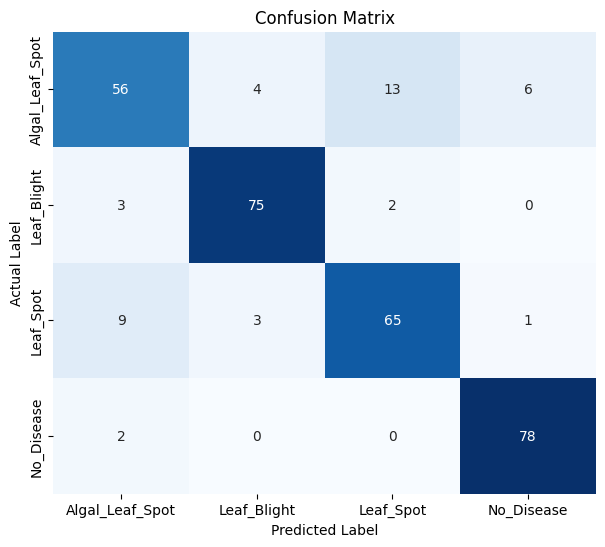

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Initialize the SVM model with RBF kernel & training it
svm_model = SVC(kernel='rbf', random_state=1)
svm_model.fit(X_train_scaled, y_train)

# Predict using the trained model
y_pred_svm = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# Evaluate the performance
print("SVM model Performance:")
print(f"Model Accuracy: {svm_accuracy * 100:.2f}%")
print("===============================")
print(classification_report(y_test, y_pred_svm))

# Compute 4x4 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# **Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.1, 1, 10, 100],          # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernels to try
    'gamma': ['scale', 'auto'], # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
    'degree': [1, 2, 3, 4, 5],              # Degree for 'poly' kernel
    'coef0': [0, 0.1, 1]
}

# Create the SVM model
svm = SVC()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=3, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

# Evaluate the best model
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Best Model: {accuracy * 100:.2f}%")

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best Hyperparameters: {'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Accuracy with Best Model: 91.17%


Best SVM model Accuracy:
Model Accuracy: 91.17%
Classification Report: 

                 precision    recall  f1-score   support

Algal_Leaf_Spot       0.89      0.82      0.86        79
    Leaf_Blight       0.94      0.91      0.92        80
      Leaf_Spot       0.88      0.91      0.89        78
     No_Disease       0.94      1.00      0.97        80

       accuracy                           0.91       317
      macro avg       0.91      0.91      0.91       317
   weighted avg       0.91      0.91      0.91       317



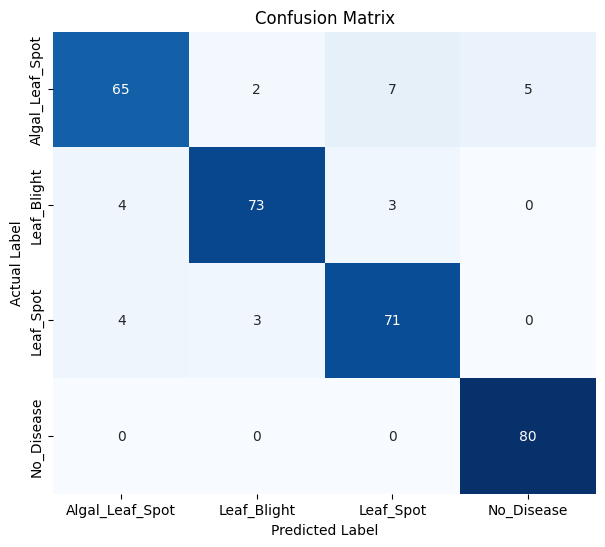

In [ ]:
svm_accuracy = accuracy_score(y_test, y_pred)

# Evaluate the performance
print("Best SVM model Accuracy:")
print(f"Model Accuracy: {svm_accuracy * 100:.2f}%")
print("===============================")
print("Classification Report: \n")
print(classification_report(y_test, y_pred))
print("===============================")
# Compute 4x4 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

### Testing against Augmented Images/ Stress Test

In [9]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model and the scaler using joblib
model_path = 'C:\\Users\\Travi\\PycharmProjects\\FYP\\model\\SVM_bestModel.pkl'

try:
    loaded_model = joblib.load(model_path)
    print(f"Model loaded successfully from {model_path} using joblib")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
    exit()

features_path = 'stressTest_features.csv'

try:
    features_df = pd.read_csv(features_path)
    print(f"Features loaded successfully from {features_path}")
except FileNotFoundError:
    print(f"Error: Features file not found at {features_path}")
    exit()

# Separate features (X) and potential labels (y)
X_stress_test = None
y_stress_test = None
has_labels = False

if 'Class' in features_df.columns:
    X_stress_test = features_df.drop(columns=['Class', 'Split'], errors='ignore')
    y_stress_test = features_df['Class']
    has_labels = True
    print("Separated features and class labels.")
else:
    X_stress_test = features_df.drop(columns=['Split'], errors='ignore') if 'Split' in features_df.columns else features_df
    print("Note: The CSV file does not contain a 'Class' column. Only predictions will be generated.")

# Normalize the features
scaler = StandardScaler()
X_stress_test_scaled = scaler.fit_transform(X_stress_test)
print("Features normalized using a new StandardScaler (as loaded scaler was not found).")

# Make predictions
predictions = None
try:
    predictions = loaded_model.predict(X_stress_test_scaled)
    print("Predictions generated successfully.")
except Exception as e:
    print(f"Error during prediction: {e}")
    exit()

# Evaluate and display results if labels are available
if has_labels and predictions is not None:
    accuracy = accuracy_score(y_stress_test, predictions)
    report = classification_report(y_stress_test, predictions)
    cm = confusion_matrix(y_stress_test, predictions)

    print("\n==================== Evaluation Metrics ====================")
    print(f"Stress Test Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", report)
    print("============================================================")
else:
    print("\nNo predictions were generated.")

Model loaded successfully from C:\Users\Travi\PycharmProjects\FYP\model\SVM_bestModel.pkl using joblib
Features loaded successfully from stressTest_features.csv
Separated features and class labels.
Features normalized using a new StandardScaler (as loaded scaler was not found).
Predictions generated successfully.

==================== Evaluation Metrics ====================
Stress Test Accuracy: 82.14%

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       0.77      0.80      0.78        64
    Leaf_Blight       0.89      0.78      0.83        64
      Leaf_Spot       0.85      0.75      0.80        60
     No_Disease       0.79      0.95      0.87        64

       accuracy                           0.82       252
      macro avg       0.83      0.82      0.82       252
   weighted avg       0.83      0.82      0.82       252



## Saving the best SVM model

In [ ]:
import joblib

joblib.dump(best_svm_model, 'SVM_bestModel.pkl')
print("The model is successfully saved! ")

The model is successfully saved! 


# ***Random Forest model***

## Building the Baseline Model

Random Forest model Performance:
Model Accuracy: 88.96%
                 precision    recall  f1-score   support

Algal_Leaf_Spot       0.87      0.82      0.84        79
    Leaf_Blight       0.89      0.94      0.91        80
      Leaf_Spot       0.86      0.81      0.83        78
     No_Disease       0.93      0.99      0.96        80

       accuracy                           0.89       317
      macro avg       0.89      0.89      0.89       317
   weighted avg       0.89      0.89      0.89       317



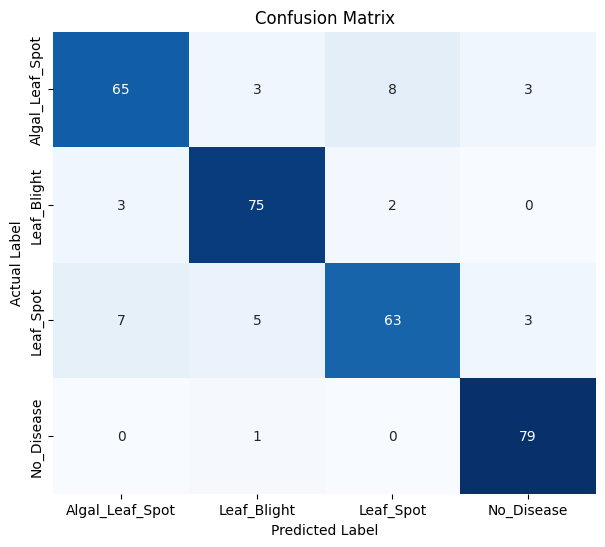

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

# Training the model and making predictions
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Evaluate the performance
print("Random Forest model Performance:")
print(f"Model Accuracy: {rf_accuracy * 100:.2f}%")
print("===============================")
print(classification_report(y_test, y_pred_rf))
print("===============================")

# Compute 4x4 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot the Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

## Hyperparameter Tuning

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 30, 50, 100, 200],
    'max_depth': [5,10,30,None],
    'criterion': ['gini','entropy','log_loss'],
    'min_samples_split': [2,3,4]
}

randFor = RandomForestClassifier()
grid_search = GridSearchCV(randFor, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Train on dataset and saving best model
grid_search.fit(X_train, y_train)
bestRandFor = grid_search.best_estimator_

# Best parameters from grid search
print(f"Best Hyperparameters: {grid_search.best_params_}")

y_pred = bestRandFor.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Best Model: {accuracy * 100:.2f}%")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Hyperparameters: {'criterion': 'log_loss', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy of Best Model: 89.59%


Classification Report: 

                 precision    recall  f1-score   support

Algal_Leaf_Spot       0.88      0.86      0.87        79
    Leaf_Blight       0.89      0.93      0.91        80
      Leaf_Spot       0.89      0.83      0.86        78
     No_Disease       0.92      0.96      0.94        80

       accuracy                           0.90       317
      macro avg       0.90      0.90      0.89       317
   weighted avg       0.90      0.90      0.90       317



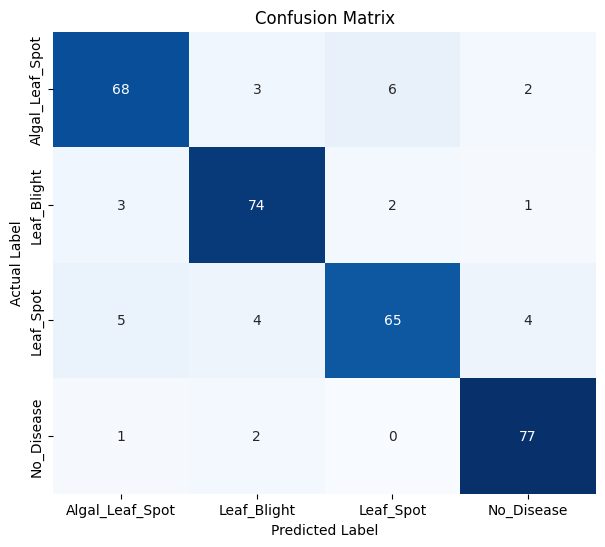

In [ ]:
print("===============================")
print("Classification Report: \n")
print(classification_report(y_test, y_pred))
print("===============================")
# Compute 4x4 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

### Testing on separate Stress Test data

In [7]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model and the scaler using joblib
model_path = 'C:\\Users\\Travi\\PycharmProjects\\FYP\\model\\RandomForest_bestModel.pkl'

try:
    loaded_model = joblib.load(model_path)
    print(f"Model loaded successfully from {model_path} using joblib")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
    exit()
except Exception as e:
    print(f"Error loading the model with joblib: {e}")
    exit()

features_path = 'stressTest_features.csv'
try:
    features_df = pd.read_csv(features_path)
    print(f"Features loaded successfully from {features_path}")
except FileNotFoundError:
    print(f"Error: Features file not found at {features_path}")
    exit()
except Exception as e:
    print(f"Error loading the features: {e}")
    exit()

X_stress_test = None
y_stress_test = None
has_labels = False

if 'Class' in features_df.columns:
    X_stress_test = features_df.drop(columns=['Class', 'Split'], errors='ignore')
    y_stress_test = features_df['Class']
    has_labels = True
    print("Separated features and class labels.")
else:
    X_stress_test = features_df.drop(columns=['Split'], errors='ignore') if 'Split' in features_df.columns else features_df
    print("Note: The CSV file does not contain a 'Class' column. Only predictions will be generated.")

# Make predictions
predictions = None
try:
    predictions = loaded_model.predict(X_stress_test)
    print("Predictions generated successfully.")
except Exception as e:
    print(f"Error during prediction: {e}")
    exit()

# Evaluate and display results if labels are available
if has_labels and predictions is not None:
    accuracy = accuracy_score(y_stress_test, predictions)
    report = classification_report(y_stress_test, predictions)
    cm = confusion_matrix(y_stress_test, predictions)

    print("\n==================== Evaluation Metrics ====================")
    print(f"Stress Test Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", report)
    print("============================================================")
elif predictions is not None:
    print("\nPredictions:\n", predictions)
else:
    print("\nNo predictions were generated.")

Model loaded successfully from C:\Users\Travi\PycharmProjects\FYP\model\RandomForest_bestModel.pkl using joblib
Features loaded successfully from stressTest_features.csv
Separated features and class labels.
Predictions generated successfully.

==================== Evaluation Metrics ====================
Stress Test Accuracy: 81.35%

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       0.77      0.80      0.78        64
    Leaf_Blight       0.78      0.84      0.81        64
      Leaf_Spot       0.88      0.73      0.80        60
     No_Disease       0.84      0.88      0.85        64

       accuracy                           0.81       252
      macro avg       0.82      0.81      0.81       252
   weighted avg       0.82      0.81      0.81       252



In [ ]:
import joblib

joblib.dump(bestRandFor, 'RandomForest_bestModel.pkl')
print("The model is successfully saved! ")

The model is successfully saved! 
